In [31]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

### Test on oscillator

This example visualizes that in some cases L-BFGS converges to the optimum in just a few iterations. However, if this optimum turns out to be non-global, no further network training occurs.

In [211]:
output_folder = os.path.join(os.getcwd(), "images")
os.makedirs(output_folder, exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [212]:
def exact_solution(d, w0, t):
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

In [213]:
class PINN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        self.fch = nn.Sequential(*[nn. Sequential(*[ nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [214]:
class PINNTrainer:
    def __init__(self, model, optimizer, t_boundary, t_physics, mu, k, display_every):
        self.model = model
        self.optimizer = optimizer
        self.t_boundary = t_boundary
        self.t_physics = t_physics
        self.mu = mu
        self.k = k
        self.display_every = display_every
        self.loss_history = []
        self.loss = 0

    def train(self, epochs):
        self.model.train()
        for epoch in range(epochs):

            def closure():
                self.optimizer.zero_grad()

                lambda1, lambda2 = 1e-1, 1e-4

                # Boundary loss
                u_pred_boundary = self.model(self.t_boundary)
                loss1 = torch.mean((u_pred_boundary - 1)**2)
                dudt_boundary = torch.autograd.grad(u_pred_boundary, 
                                                    self.t_boundary, 
                                                    torch.ones_like(u_pred_boundary), 
                                                    create_graph=True)[0]
                loss2 = torch.mean((dudt_boundary - 0)**2)

                # Physics loss
                u_pred_physics = self.model(self.t_physics)
                dudt_physics = torch.autograd.grad(u_pred_physics, 
                                                   self.t_physics, 
                                                   torch.ones_like(u_pred_physics), 
                                                   create_graph=True)[0]
                d2udt2_physics = torch.autograd.grad(dudt_physics, 
                                                     self.t_physics, 
                                                     torch.ones_like(dudt_physics), 
                                                     create_graph=True)[0]
                loss3 = torch.mean((d2udt2_physics + self.mu * dudt_physics + self.k * u_pred_physics)**2)

                # Total loss
                self.loss = loss1 + lambda1 * loss2 + lambda2 * loss3
                self.loss.backward()

                return self.loss

            self.optimizer.step(closure)

            if not epoch % self.display_every:
                self.loss_history.append(self.loss.item())
                # print(f'Epoch {epoch + 1}/{epochs}, Loss: {self.loss_history[-1]}')

    def plot_loss_history(self):
        plt.plot(self.loss_history)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.show()

In [215]:
input_size = 1
output_size = 1
hidden_size = 16
num_hidden_layers = 2
display_every = 10

# Initialize the PINN models
pinn_model_adam = PINN(input_size, output_size, hidden_size, num_hidden_layers)
pinn_model_lbfgs = PINN(input_size, output_size, hidden_size, num_hidden_layers)

In [216]:
# Data for the PINN
t_boundary = torch.tensor(0.).view(-1, 1).requires_grad_(True)
t_physics = torch.linspace(0, 1, 30).view(-1, 1).requires_grad_(True)
d, w0 = 2, 20
mu, k = 2*d, w0**2

In [217]:
lbfgs_optimizer = torch.optim.LBFGS(params=pinn_model_lbfgs.parameters(),
                                    lr=0.1, 
                                    max_iter = 250, 
                                    max_eval = None, 
                                    tolerance_grad = 1e-05, 
                                    tolerance_change = 1e-10, 
                                    history_size = 100, 
                                    line_search_fn = 'strong_wolfe')
trainer_lbfgs = PINNTrainer(pinn_model_lbfgs, lbfgs_optimizer, 
                            t_boundary, t_physics, mu, k, display_every)

trainer_lbfgs.train(15000)
# trainer_lbfgs.plot_loss_history()

In [218]:
adam_optimizer = torch.optim.Adam(params=pinn_model_adam.parameters(), lr=1e-3)
trainer_adam = PINNTrainer(pinn_model_adam, adam_optimizer, 
                           t_boundary, t_physics, mu, k, display_every)

trainer_adam.train(15000)
# trainer_adam.plot_loss_history()

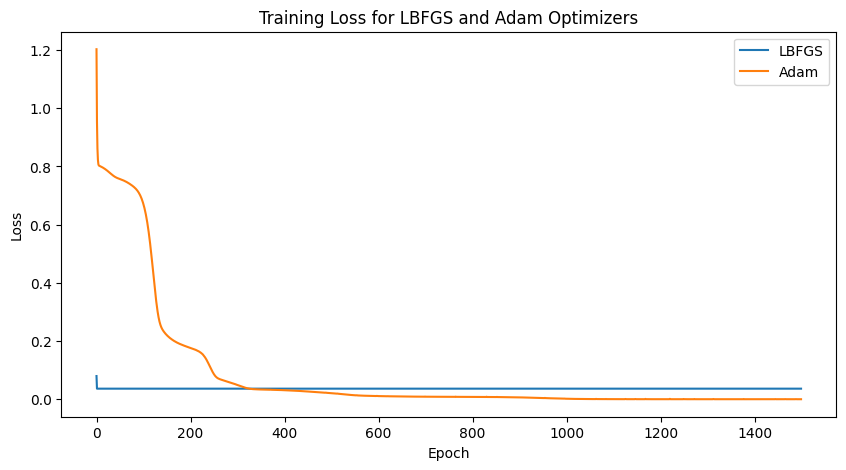

In [219]:
# Plot loss history of the two optimizers
plt.figure(figsize=(10, 5))
# PLot in log scale
# plt.yscale('log')

plt.plot(trainer_lbfgs.loss_history, label='LBFGS')
plt.plot(trainer_adam.loss_history, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss for LBFGS and Adam Optimizers')
plt.legend()
plt.show()

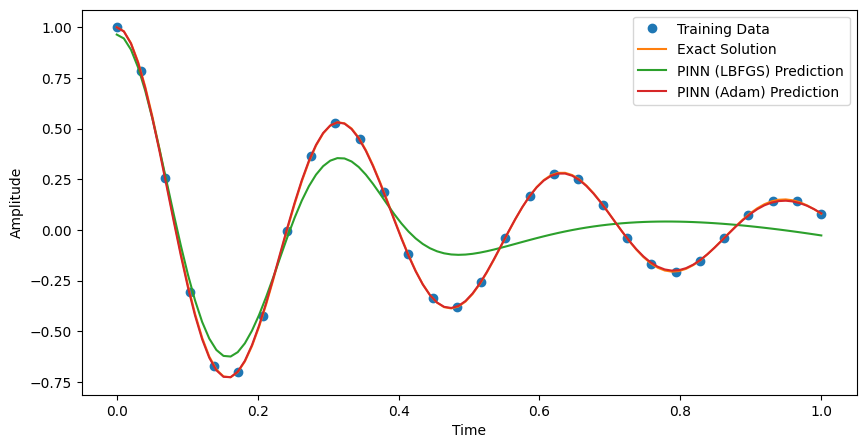

In [223]:
# Plot the results
with torch.no_grad():
    t_test = torch.linspace(0, 1, 100).view(-1, 1)
    u_learning = exact_solution(d, w0, t_physics)
    u_exact = exact_solution(d, w0, t_test)
    u_pred_lbfgs = pinn_model_lbfgs(t_test)
    u_pred_adam = pinn_model_adam(t_test)

plt.figure(figsize=(10, 5))
plt.plot(t_physics.detach().numpy(), u_learning.detach().numpy(), 'o', label='Training Data')
plt.plot(t_test.numpy(), u_exact.numpy(), label='Exact Solution')
plt.plot(t_test.numpy(), u_pred_lbfgs.numpy(), label='PINN (LBFGS) Prediction')
plt.plot(t_test.numpy(), u_pred_adam.numpy(), label='PINN (Adam) Prediction')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

### Test on linear regression

This example clearly demonstrates how L-BFGS may not converge to the global minimum and be hidden at some non-optimal point

In [18]:
class LinearModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super().__init__()
        self.hidden_layers = nn.ModuleList()
        
        # Input layer
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        
        # Output layer
        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for layer in self.hidden_layers:
            x = torch.tanh(layer(x))
        return self.output_layer(x)

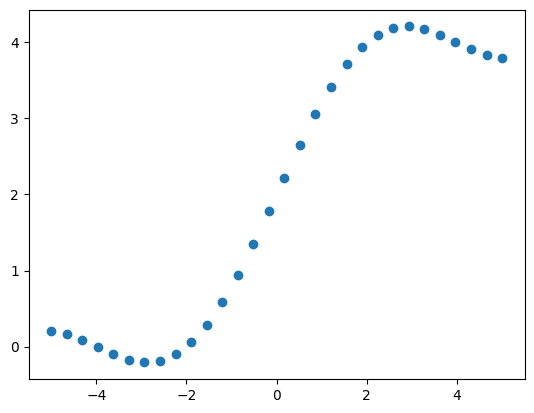

In [19]:
x = torch.linspace(-5, 5, steps=30)
y = 1/2 * x + torch.sin(torch.pi * x/4) + 2
x, y = x.reshape(-1, 1), y.reshape(-1, 1)

plt.scatter(x, y)
plt.show()

In [20]:
class DummyData(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [21]:
# Determine if it is a cpu or a gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# DataSet
dummy_data = DummyData(x.to(device), y.to(device))

# Training parameters
criterion = nn.MSELoss()

cuda:0


In [39]:
N_runs = 5

avg_loss_history_adam = []

for run in range(N_runs):
    lm_adam = LinearModel(1, [40], 1)
    lm_adam.to(device)
    optimizer = optim.Adam(lm_adam.parameters(), weight_decay=0.0001)
    loss_history_adam = []


    epochs = 100
    for epoch in range(epochs):
        running_loss = 0.0
        
        for i, (x, y) in enumerate(dummy_data):

            x_ = torch.autograd.Variable(x, requires_grad=True)
            y_ = torch.autograd.Variable(y)

            # Forward pass
            y_pred = lm_adam(x_)

            # Compute loss
            loss = criterion(y_pred, y_)

            # Zero gradients, backward pass, and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the running loss
            running_loss += loss.item()

        # Save loss history
        if epoch % 10 == 0:
            loss_history_adam.append(running_loss)
            # print(f"Epoch: {epoch + 1:02}/{epochs} Loss: {running_loss:.5e}")

    avg_loss_history_adam.append(loss_history_adam)

avg_loss_history_adam = torch.tensor(avg_loss_history_adam).mean(dim=0).tolist()

In [ ]:
N_runs = 5

avg_loss_history_lbfgs = []

for run in range(N_runs):
    lm_lbfgs = LinearModel(1, [40], 1)
    lm_lbfgs.to(device)
    optimizer = optim.LBFGS(lm_lbfgs.parameters())
    loss_history_lbfgs = []

    # best_loss = float('inf')
    # patience = 10

    epochs = 100
    for epoch in range(epochs):
        running_loss = 0.0

        for i, (x, y) in enumerate(dummy_data):

            x_ = torch.autograd.Variable(x, requires_grad=True)
            y_ = torch.autograd.Variable(y)

            def closure():
                # Zero gradients
                optimizer.zero_grad()

                # Forward pass
                y_pred = lm_lbfgs(x_)

                # Compute loss
                loss = criterion(y_pred, y_)

                # Backward pass
                loss.backward()

                return loss

            # Update weights
            optimizer.step(closure)

            # Update the running loss
            loss = closure()
            running_loss += loss.item()        

        # Save loss history
        if epoch % 10 == 0:
            loss_history_lbfgs.append(running_loss)
            print(f"Epoch: {epoch + 1:02}/{epochs} Loss: {running_loss:.5e}")

        # # Early stopping
        # if running_loss < best_loss:
        #     best_loss = running_loss
        #     patience_counter = 0
        # elif running_loss == best_loss:
        #     patience_counter += 1
        #     if patience_counter >= patience:
        #         # print(f"Early stopping at epoch {epoch + 1} with best loss: {best_loss}")
        #         break
            
    avg_loss_history_lbfgs.append(loss_history_lbfgs)

avg_loss_history_lbfgs = torch.tensor(avg_loss_history_lbfgs).mean(dim=0).tolist()

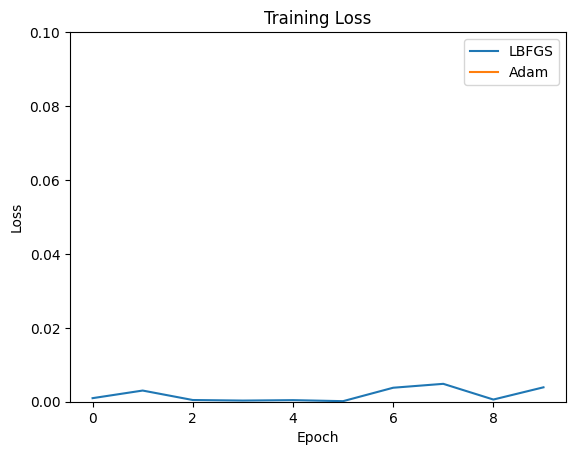

In [ ]:
# Plot loss history
plt.plot(avg_loss_history_lbfgs, label='LBFGS')
plt.plot(avg_loss_history_adam, label='Adam')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.1)
plt.legend()
plt.title('Training Loss')
plt.show()

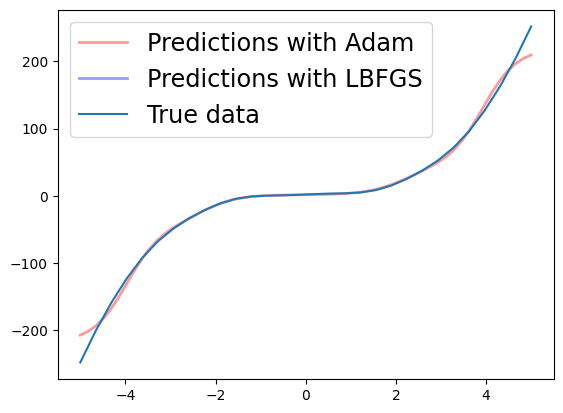

In [231]:
import matplotlib.pyplot as plt

x_for_pred = torch.linspace(-5, 5, steps=60).reshape(-1, 1).to(device)
with torch.no_grad():
    y_pred_adam = lm_adam(torch.autograd.Variable(x_for_pred)).cpu().data.numpy()
    y_pred_lbfgs = lm_lbfgs(torch.autograd.Variable(x_for_pred)).cpu().data.numpy()

x = torch.linspace(-5, 5, steps=30)
y = 2 * x ** 3 + torch.sin(torch.pi * x) + 2
x, y = x.reshape(-1, 1), y.reshape(-1, 1)
x_plot = x.cpu().data.numpy()
y_plot = y.cpu().data.numpy()

# Prediction data
num_pred_points = x_for_pred.shape[0]
x_for_pred = x_for_pred.reshape(num_pred_points,).cpu().data.numpy()
y_pred_adam = y_pred_adam.reshape(num_pred_points,)
y_pred_lbfgs = y_pred_lbfgs.reshape(num_pred_points,)

plt.plot(x_for_pred, y_pred_adam, "r", label="Predictions with Adam", alpha=0.4, lw=2)
plt.plot(x_for_pred, y_pred_lbfgs, "b", label="Predictions with LBFGS", alpha=0.4, lw=2)
plt.plot(x_plot, y_plot, label="True data")
plt.legend(fontsize="xx-large")
plt.show()

### Dependence of the value of the loss function on the epoch

In this example, the dependence of the value of the loss function on the epoch and the final result of restoring the dependence are visualized

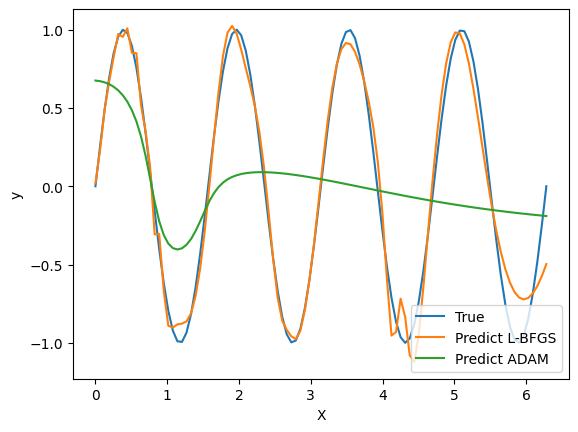

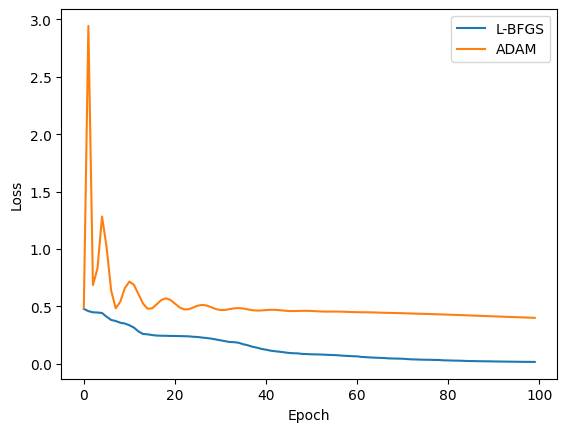

In [40]:
torch.manual_seed(42)
X = torch.unsqueeze(torch.linspace(0, 2 * torch.pi, 100), dim=1)
y = torch.sin(4*X)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        
        # Input layer
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        
        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        
        # Output layer
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        return self.layers[-1](x)

input_size = 1
hidden_sizes = [64, 64]
output_size = 1

loss_history = {}
use_optimizers = ["lbfgs", "adam"]
save_predictions = {}

epochs = 100

for use_optimizer in use_optimizers:
    model = NeuralNetwork(input_size, hidden_sizes, output_size)
    criterion = nn.MSELoss()

    if use_optimizer == "lbfgs":
        optimizer = optim.LBFGS(model.parameters(), lr=0.01, max_iter=20, line_search_fn='strong_wolfe')
    else:
        optimizer = optim.Adam(model.parameters(), lr=0.01)

    loss_history[use_optimizer] = []

    def closure():
        optimizer.zero_grad()
        predictions = model(X)
        loss = criterion(predictions, y)
        loss.backward()
        return loss

    for epoch in range(epochs):
        if use_optimizer == "adam":
            predictions = model(X)
            loss = criterion(predictions, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        else:
            optimizer.step(closure)
            loss = closure()

        loss_history[use_optimizer].append(loss.item())
        # print(f"Optimizer {use_optimizer}, Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

    save_predictions[use_optimizer] = model(X).detach().numpy()

with torch.no_grad():
    plt.plot(X.numpy(), y.numpy(), label='True')
    plt.plot(X.numpy(), save_predictions[use_optimizers[0]], label='Predict L-BFGS')
    plt.plot(X.numpy(), save_predictions[use_optimizers[1]], label='Predict ADAM')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.legend()
    plt.show()

plt.plot(loss_history[use_optimizers[0]], label = 'L-BFGS')
plt.plot(loss_history[use_optimizers[1]], label = 'ADAM')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Adding a Hybrid Optimizer

A simplified hybrid optimizer class has been implemented to test the switching mechanism and hyperparameters

Epoch 1/1000, Loss: 0.7540498375892639
Epoch 51/1000, Loss: 0.4623737335205078
Epoch 101/1000, Loss: 0.4220553934574127
Epoch 151/1000, Loss: 0.37557005882263184
Epoch 201/1000, Loss: 0.3473941385746002
Epoch 251/1000, Loss: 0.320119708776474
Epoch 301/1000, Loss: 0.23317044973373413
Epoch 351/1000, Loss: 0.17247936129570007
Switching to L-BFGS at epoch 378 with loss 0.09636916220188141
Epoch 401/1000, Loss: 0.0017848662100732327
Epoch 451/1000, Loss: 3.638619455159642e-05
Epoch 501/1000, Loss: 1.9005916328751482e-05
Epoch 551/1000, Loss: 1.896981666504871e-05
Epoch 601/1000, Loss: 1.895429886644706e-05
Epoch 651/1000, Loss: 1.894239176181145e-05
Epoch 701/1000, Loss: 1.893447188194841e-05
Epoch 751/1000, Loss: 1.8930437363451347e-05
Epoch 801/1000, Loss: 1.8925516997114755e-05
Epoch 851/1000, Loss: 1.8919781723525375e-05
Epoch 901/1000, Loss: 1.8915981854661368e-05
Epoch 951/1000, Loss: 1.891471038106829e-05


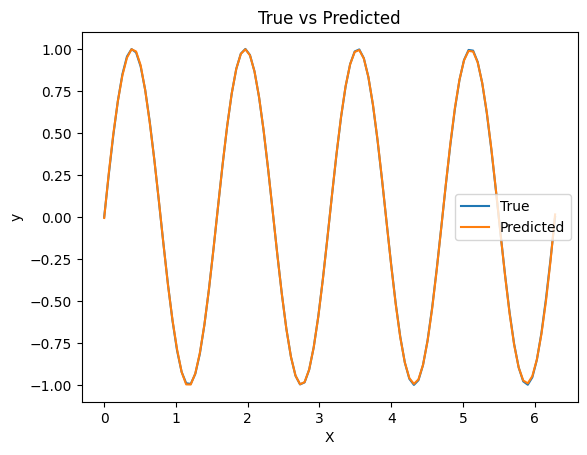

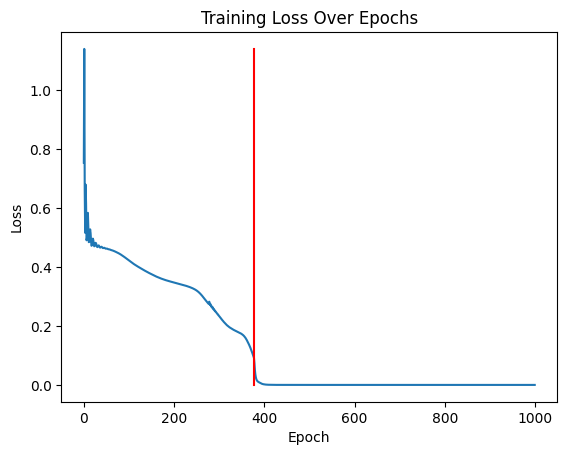

In [42]:
model = NeuralNetwork(input_size, hidden_sizes, output_size)
criterion = nn.MSELoss()

optimizer_adam = optim.Adam(model.parameters(), lr=0.01)
optimizer_lbfgs = optim.LBFGS(model.parameters(), lr=0.01)

class HybridOptimizer:
    def __init__(self, model, criterion, optimizer_adam, optimizer_lbfgs, switch_epoch, switch_loss_threshold):
        self.model = model
        self.criterion = criterion
        self.optimizer_adam = optimizer_adam
        self.optimizer_lbfgs = optimizer_lbfgs
        self.switch_epoch = switch_epoch
        self.switch_loss_threshold = switch_loss_threshold
        self.current_optimizer = optimizer_adam

        self.epoch_of_switch = None

    def step(self, epoch):
        if epoch >= self.switch_epoch and self.current_optimizer == self.optimizer_adam:
            # Switch to L-BFGS if conditions are met
            loss = self.criterion(self.model(X), y)
            if loss.item() < self.switch_loss_threshold:
                print(f'Switching to L-BFGS at epoch {epoch + 1} with loss {loss.item()}')
                self.epoch_of_switch = epoch
                self.current_optimizer = self.optimizer_lbfgs

        # Perform optimization step with the current optimizer
        self.current_optimizer.step(self.closure)

    def closure(self):
        self.current_optimizer.zero_grad()
        predictions = model(X)
        loss = criterion(predictions, y)
        loss.backward()
        return loss

hybrid_optimizer = HybridOptimizer(model, criterion, optimizer_adam, optimizer_lbfgs, switch_epoch=50, switch_loss_threshold=0.1)

epochs = 1000
loss_history = []

for epoch in range(epochs):
    # Perform optimization step with the hybrid optimizer
    hybrid_optimizer.step(epoch)

    # Save loss history
    loss_history.append(criterion(model(X), y).item())

    if (epoch) % 50 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_history[-1]}")

with torch.no_grad():
    plt.plot(X.numpy(), y.numpy(), label='True')
    plt.plot(X.numpy(), model(X).numpy(), label='Predicted')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('True vs Predicted')
    plt.legend()
    plt.show()

plt.plot(loss_history)
plt.plot([hybrid_optimizer.epoch_of_switch, hybrid_optimizer.epoch_of_switch], [0, max(loss_history)], 'r')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()